## DBSCAN 정리

#### DBSCAN이란?

DBSCAN은 동일한 집단의 데이터는 서로 근접하게 분포할 것이라는 가정하에 분석을 시작합니다  

여러분께서 DBSCAN을 활용하기 위해서는 2가지 값을 지정해야 하는데요. 바로 epsilon(입실론, 반경의 크기)과 min points(민 포인트, 최소 군집의 크기)입니다.

 epsilon(반경의 크기)과 min points(최소 군집의 크기)를 데이터에 적용하면, 각 데이터들의 역할을 Core(중심점), Border(경계점), Noise(잡음/이상치)로 구분할 수 있습니다.

- epsilson : 클러스터의 반경  
- minPts : 클러스터를 이루는 개체의 최솟값  
- core point : 반경 epsilon 내에 minPts 개 이상의 점이 존재하는 중심점
- border point : 군집의 중심이 되지 못하지만 군집에 속하는 점
- noise point : 군집에 포합되지 못하는 점

#### 알고리즘 진행 순서
임의의 p점을 설정하고 그 반경에 있는 점들을 센다.  
원에 minPts 개 이상의 점이 포함되어 있으면 해당 점 p를 core point로 간주하고 원에 포함된 점들을 하나의 클러스터로 묶습니다.  
해당 원에 minPts 개 미만의 점이면 pass
모든 점을 돌아가면서 반복을 진행하고 새로운 p가 core point에 속하면 두 대 클러스터는 연결되어 있다고 하며 하나의 클러스터로 묶는다.  
모든 클러스터링과정을 어떤 점을 중심으로 해도 클러스터에 속하지 못하면 noise라 간주하며 특정 군집에 속하지만 core point가 아닌 점들을 border point라고 한다.

## 카페 데이터 dbscan

In [ ]:
!pip install folium

In [ ]:
!pip install alphashape

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from shapely.geometry import  Polygon, Point, mapping, MultiPoint
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import folium
import alphashape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 카페 데이터 읽기
dir_path = "/content/drive/MyDrive/2024-02-machine-learning/data"
file_name = "cleaned_cafe_data.csv"
cafe_data = pd.read_csv(f"{dir_path}/{file_name}")

# 카페 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(cafe_data['x'], cafe_data['y'])]
cafe_gdf = gpd.GeoDataFrame(cafe_data, geometry=geometry, crs="EPSG:4326")

# 좌표 데이터 준비
coords = np.array(list(zip(cafe_gdf.geometry.x, cafe_gdf.geometry.y)))

# 좌표 스케일링
coords_scaled = StandardScaler().fit_transform(coords)


Best eps: 0.20000000000000004, Best min_samples: 8, Best silhouette score: 0.31672502014131326


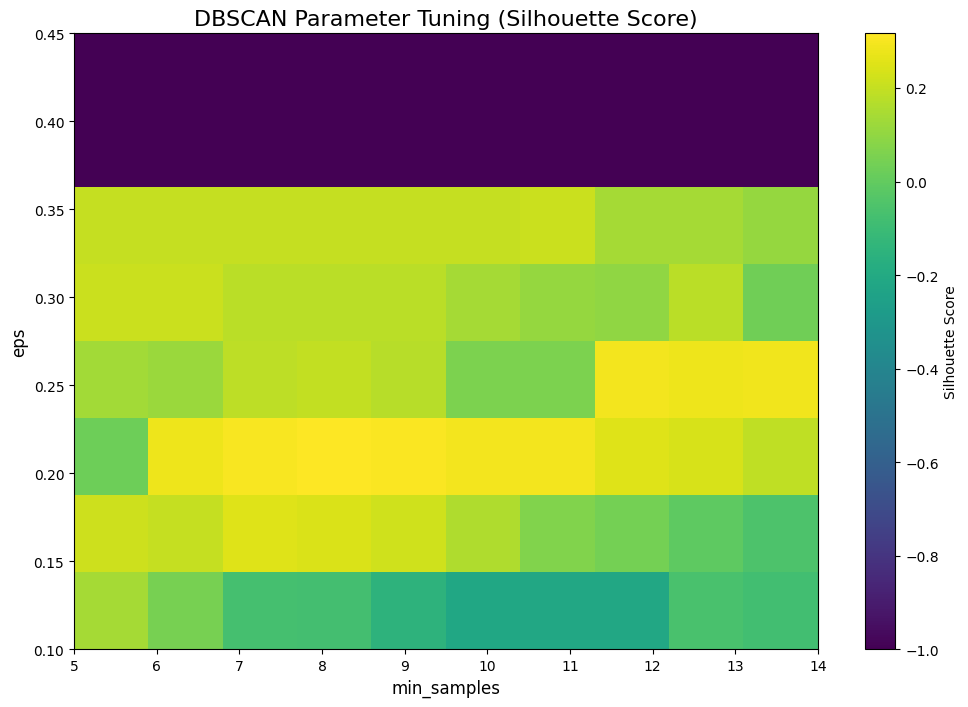

In [ ]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.5, 0.05)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

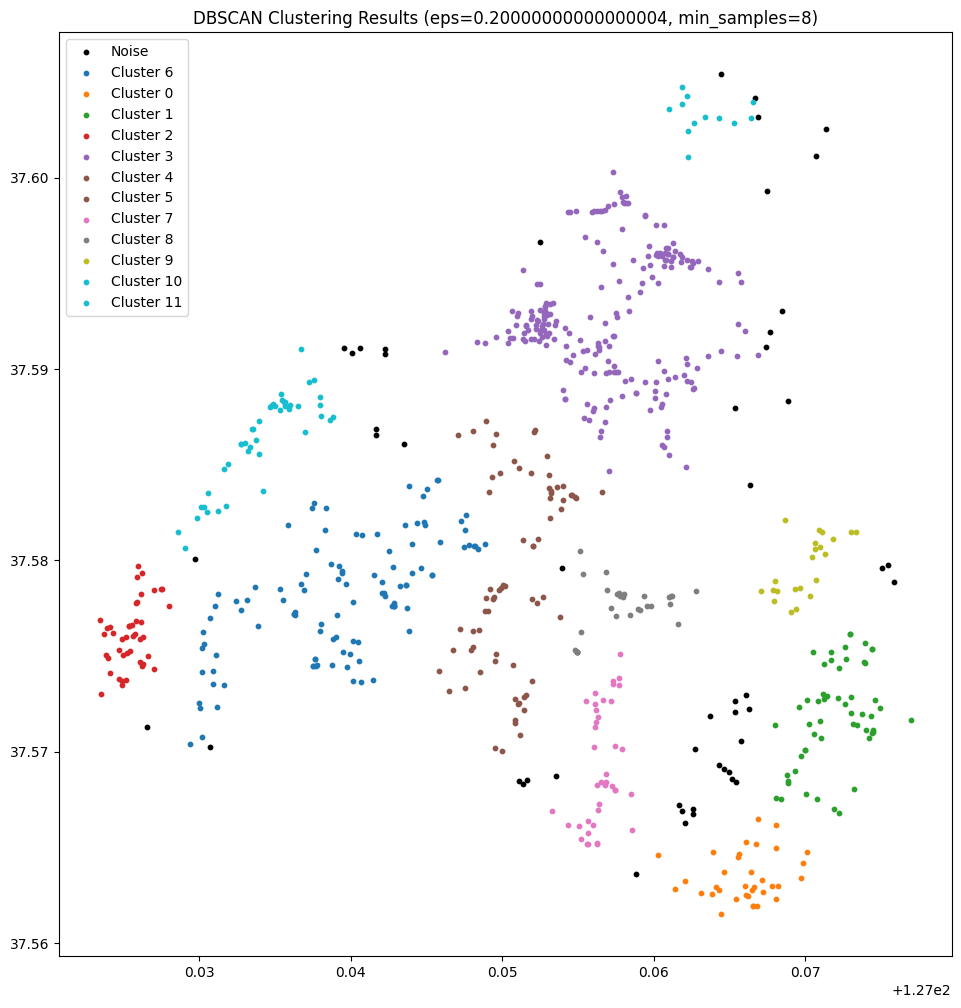

In [ ]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cafe_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = cafe_gdf['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = cafe_gdf[cafe_gdf['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()


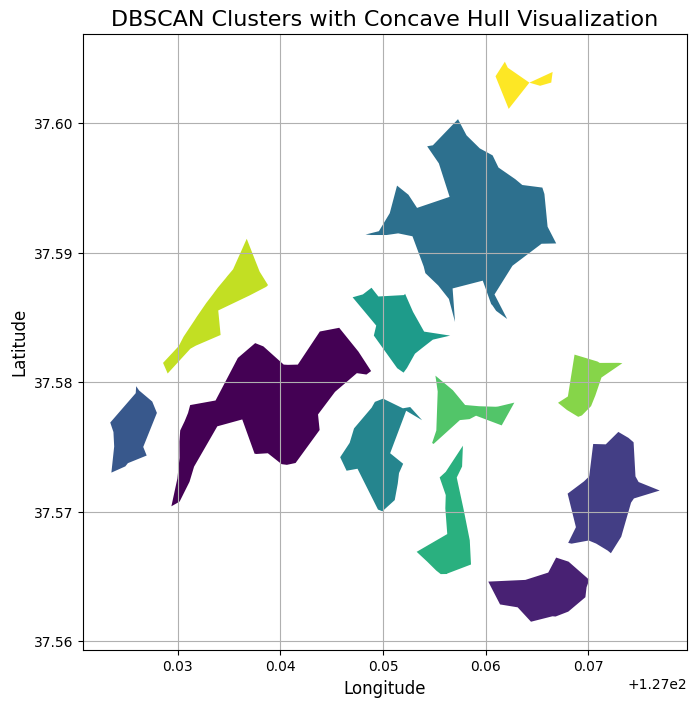

In [ ]:
# Concave Hull 계산
cluster_rows = []

for cluster in cafe_gdf['cluster'].unique():
    if cluster == -1:  # Noise는 제외
        continue

    # 특정 클러스터에 속하는 데이터 필터링
    cluster_data = cafe_gdf[cafe_gdf['cluster'] == cluster]

    # 해당 클러스터의 Concave Hull 계산
    coords = list(zip(cluster_data.geometry.x, cluster_data.geometry.y))

    # Alpha Shape을 사용하여 Concave Hull 생성
    concave_hull = alphashape.alphashape(coords, alpha=500)  # alpha 값 조정 가능

    # Concave Hull 정보 저장
    cluster_rows.append({'cluster': cluster, 'geometry': concave_hull})

# Concave Hull을 포함한 GeoDataFrame 생성
gdf_clusters = gpd.GeoDataFrame(cluster_rows, columns=['cluster', 'geometry'], crs=cafe_gdf.crs)

# Concave Hull geometries 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_clusters.plot(ax=ax, cmap='viridis', legend=True)
plt.title('DBSCAN Clusters with Concave Hull Visualization', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
print(gdf_clusters)

output_path = "/content/drive/MyDrive/2024-02-machine-learning/data/dbscaned_cafe_clusters.geojson"
gdf_clusters.to_file(output_path, driver="GeoJSON")
print(f"Convex Hull GeoDataFrame saved to {output_path}")

    cluster                                           geometry
0         6  POLYGON ((127.03387 37.57659, 127.0316 37.5734...
1         0  POLYGON ((127.06442 37.5615, 127.06312 37.5626...
2         1  POLYGON ((127.07221 37.56679, 127.07189 37.567...
3         2  POLYGON ((127.02382 37.57503, 127.02375 37.576...
4         3  POLYGON ((127.05288 37.59126, 127.05148 37.591...
5         4  POLYGON ((127.05019 37.57865, 127.05194 37.577...
6         5  POLYGON ((127.05312 37.58219, 127.05234 37.581...
7         7  POLYGON ((127.05772 37.57382, 127.05771 37.573...
8         8  POLYGON ((127.05493 37.57522, 127.05479 37.575...
9         9  POLYGON ((127.06938 37.57743, 127.06902 37.577...
10       10  POLYGON ((127.03863 37.58736, 127.037 37.58669...
11       11  MULTIPOLYGON (((127.06188 37.60473, 127.06216 ...
Convex Hull GeoDataFrame saved to /content/drive/MyDrive/2024-02-machine-learning/data/dbscaned_cafe_clusters.geojson


In [ ]:
# Folium을 사용한 시각화
folium_map = folium.Map(location=[37.5744, 127.0396], tiles="OpenStreetMap", zoom_start=14)

for _, row in gdf_clusters.iterrows():
    cluster_label = row['cluster']
    polygon = row['geometry']

    # Convex Hull을 GeoJson으로 변환
    geo_json = mapping(polygon)

    folium.GeoJson(
        geo_json,
        name=f"Cluster {cluster_label}",
        style_function=lambda x: {
            "fillColor": "#3186cc",  # 채우기 색상
            "color": "blue",         # 외곽선 색상
            "weight": 2,             # 외곽선 두께
            "fillOpacity": 0.4,      # 채우기 투명도
        },
        tooltip=f"Cluster {cluster_label}"  # 클러스터 ID 표시
    ).add_to(folium_map)

# Folium 지도 표시
folium_map

## 법인 데이터 dbscan

In [ ]:
# 법인 데이터 읽기
dir_path = "/content/drive/MyDrive/2024-02-machine-learning/data"
file_name = "corps_in_ddm.csv"
corp_data = pd.read_csv(f"{dir_path}/{file_name}")

# NaN 값 제거 (위도, 경도 열에서)
corp_data = corp_data.dropna(subset=['x', 'y'])

# 법인 데이터를 GeoDataFrame으로 변환 (EPSG:4326)
geometry = [Point(xy) for xy in zip(corp_data['x'], corp_data['y'])]
corp_gdf = gpd.GeoDataFrame(corp_data, geometry=geometry, crs="EPSG:4326")

# 법인 좌표 데이터 준비
coords = np.array(list(zip(corp_gdf.geometry.x, corp_gdf.geometry.y)))

# 좌표 스케일링
coords_scaled = StandardScaler().fit_transform(coords)

Best eps: 0.3899999999999999, Best min_samples: 10, Best silhouette score: 0.4578772515934105


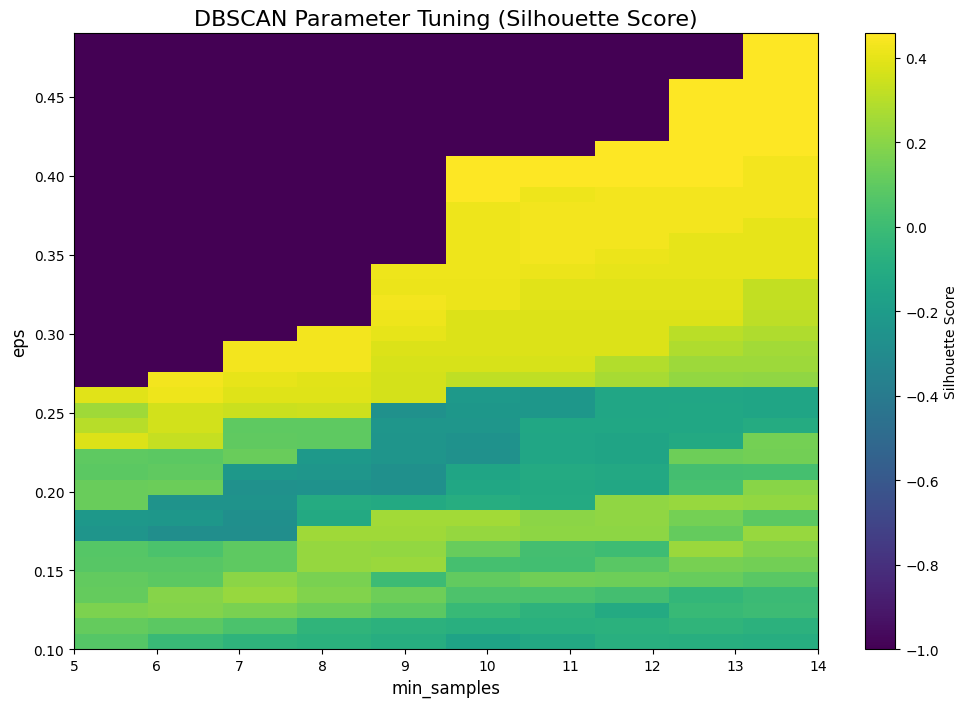

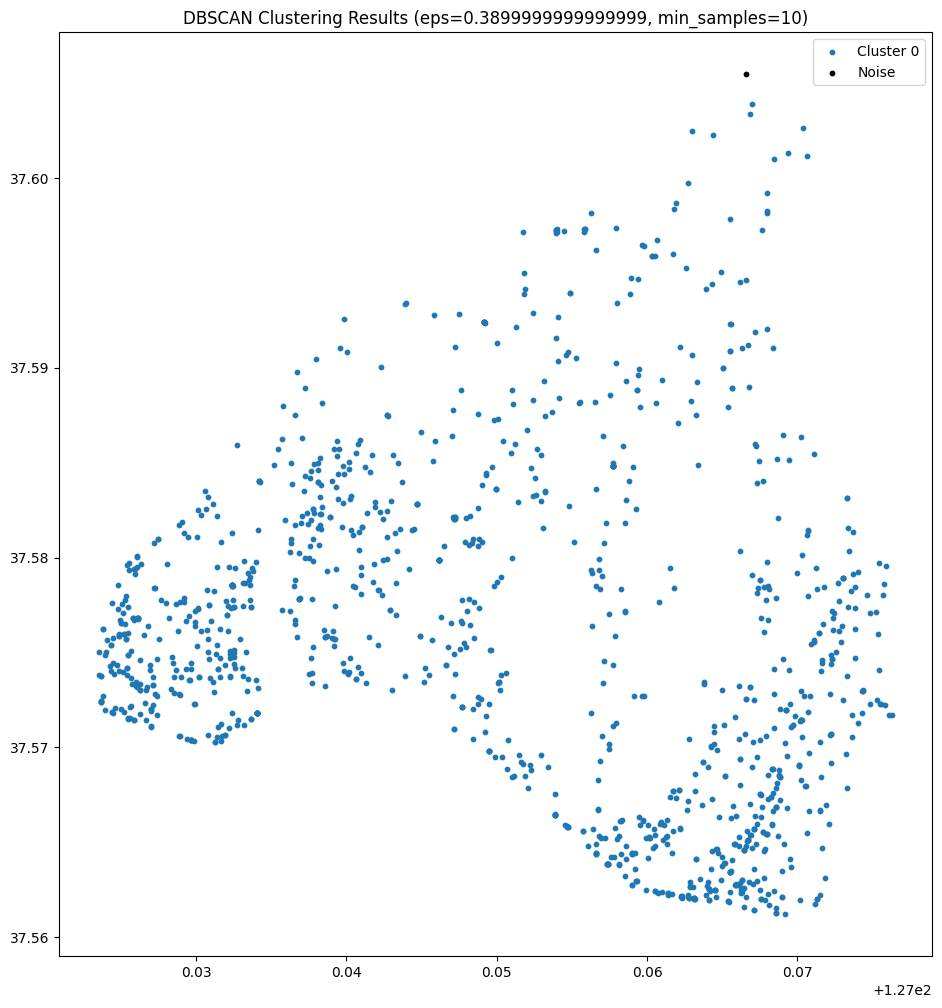

In [ ]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.5, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
corp_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = corp_gdf['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = corp_gdf[corp_gdf['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()

전체적으로 범위를 봤을 때 원하는 결과가 나오지 않는다.범위를 쪼개서 클러스터를 나눠보자.


Best eps: 0.04, Best min_samples: 11, Best silhouette score: 0.016481803495969026


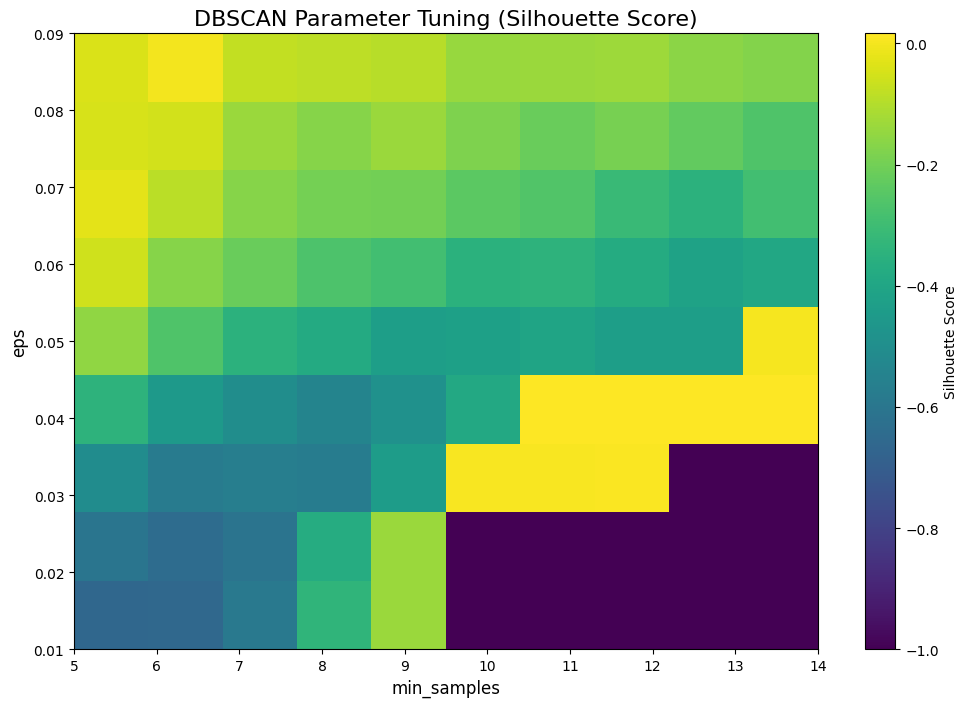

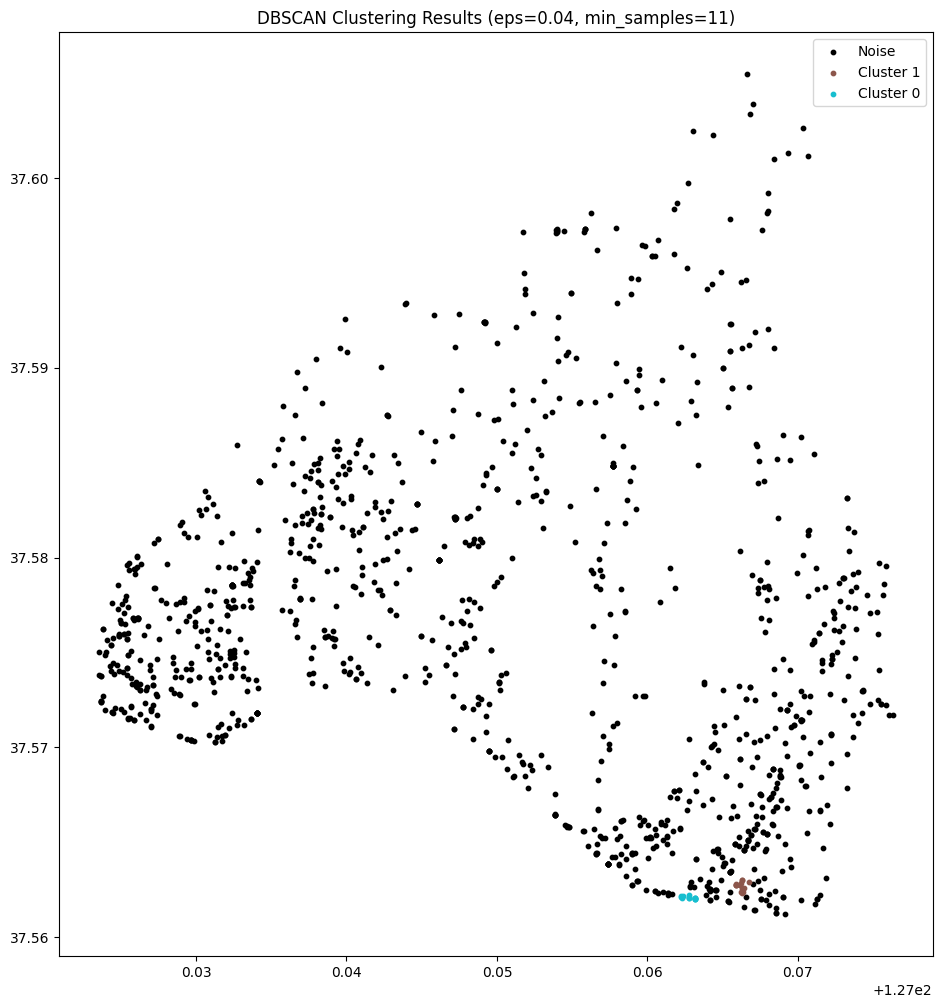

In [ ]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.01, 0.1, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
corp_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = corp_gdf['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = corp_gdf[corp_gdf['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()

Best eps: 0.17999999999999997, Best min_samples: 9, Best silhouette score: 0.25448218023616787


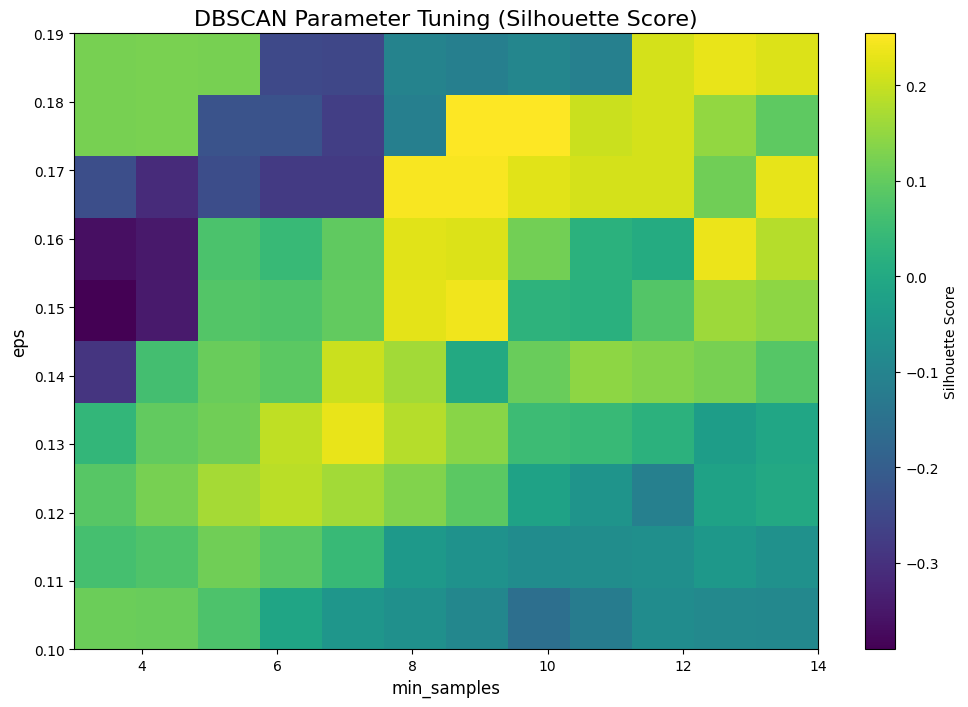

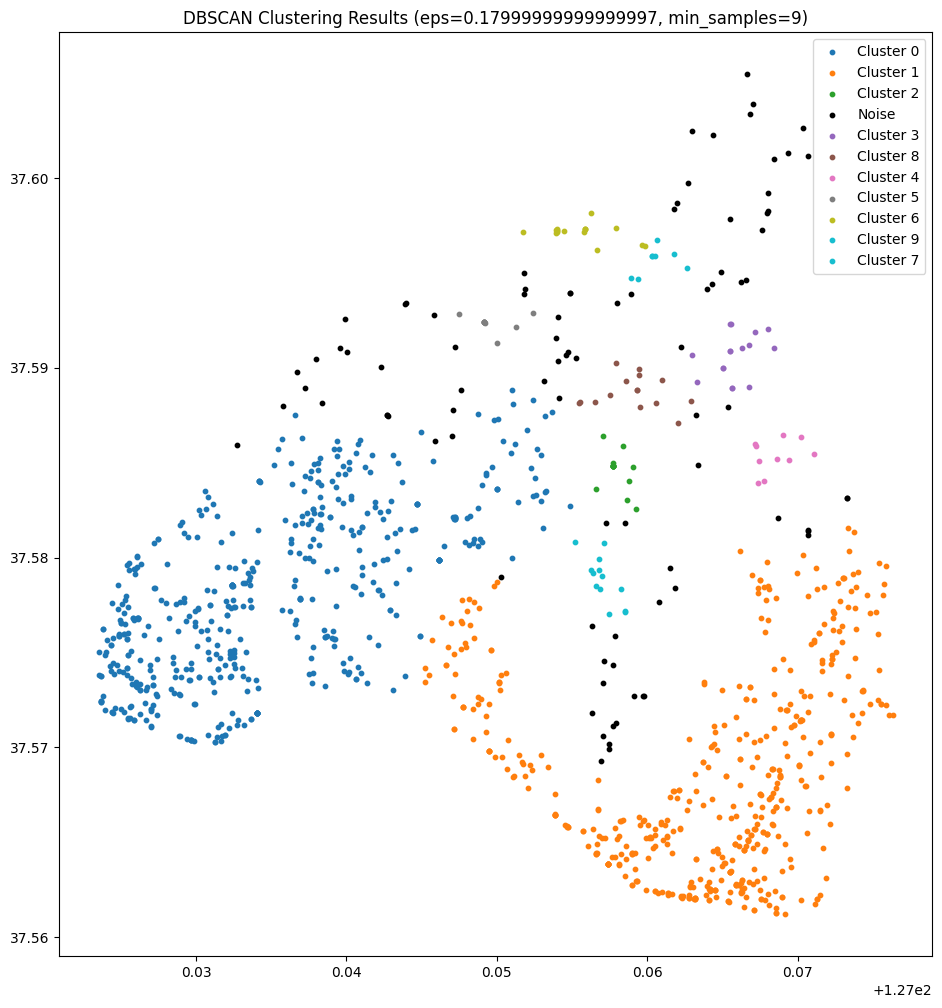

In [ ]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.1, 0.2, 0.01)  # eps 범위
min_samples_values = range(3, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
corp_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = corp_gdf['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = corp_gdf[corp_gdf['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()

Best eps: 0.2800000000000001, Best min_samples: 7, Best silhouette score: 0.43304961788929197


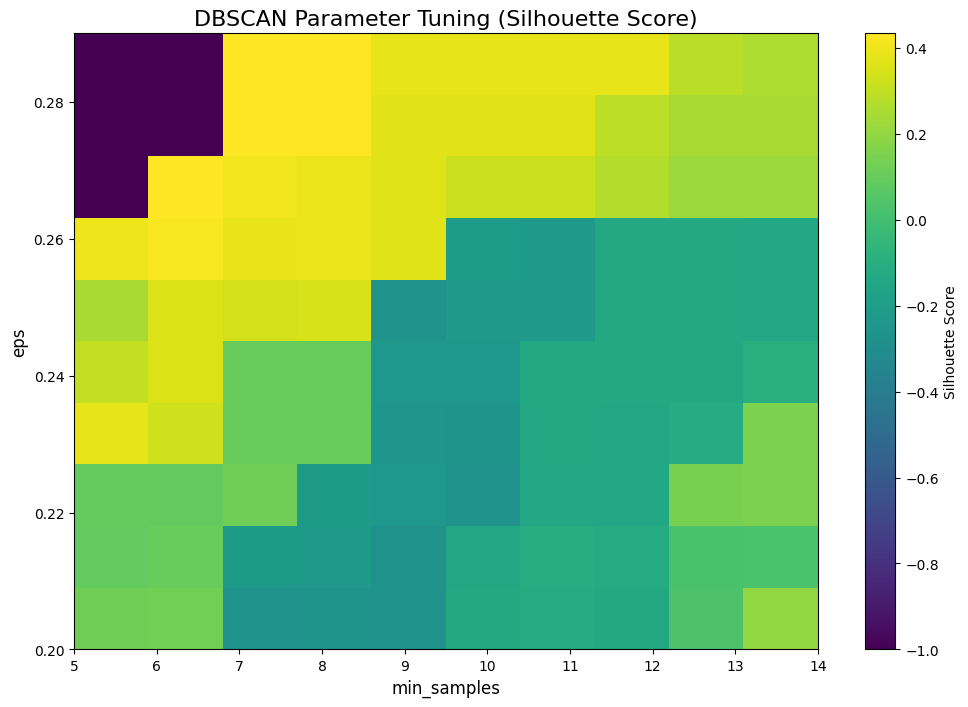

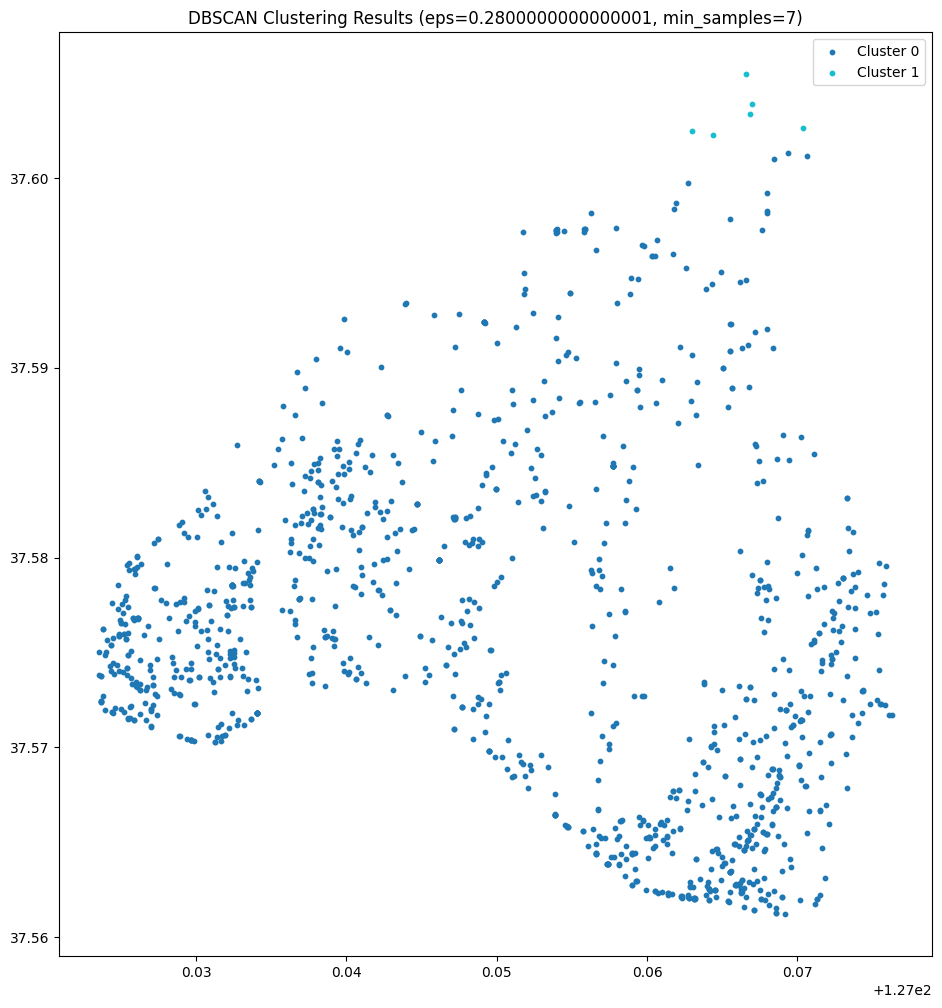

In [ ]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.2, 0.3, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
corp_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = corp_gdf['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = corp_gdf[corp_gdf['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()

Best eps: 0.39000000000000007, Best min_samples: 10, Best silhouette score: 0.4578772515934105


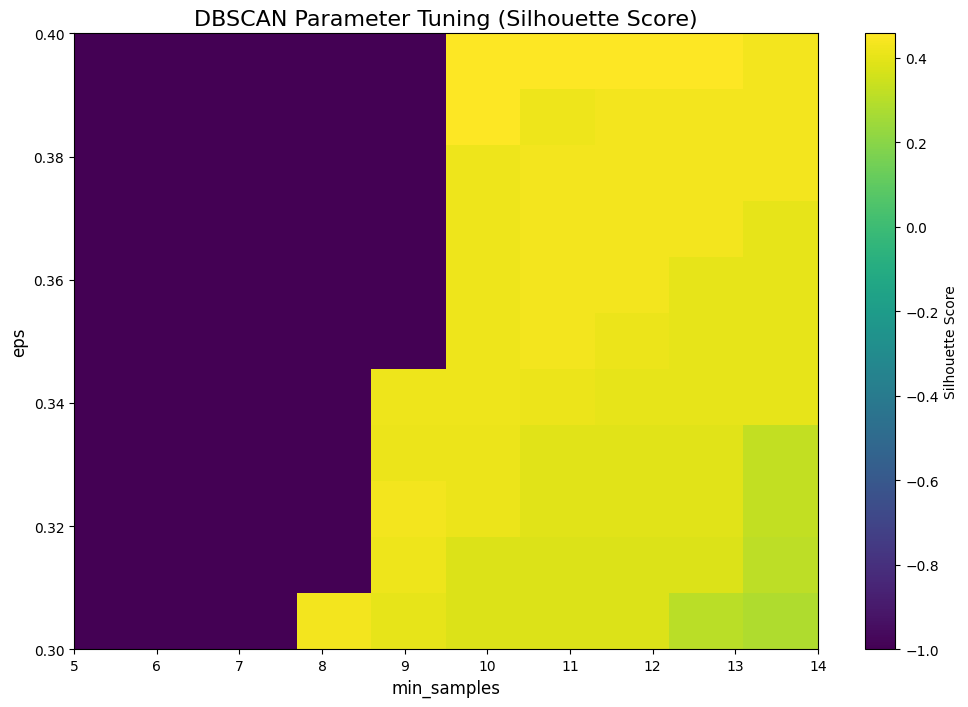

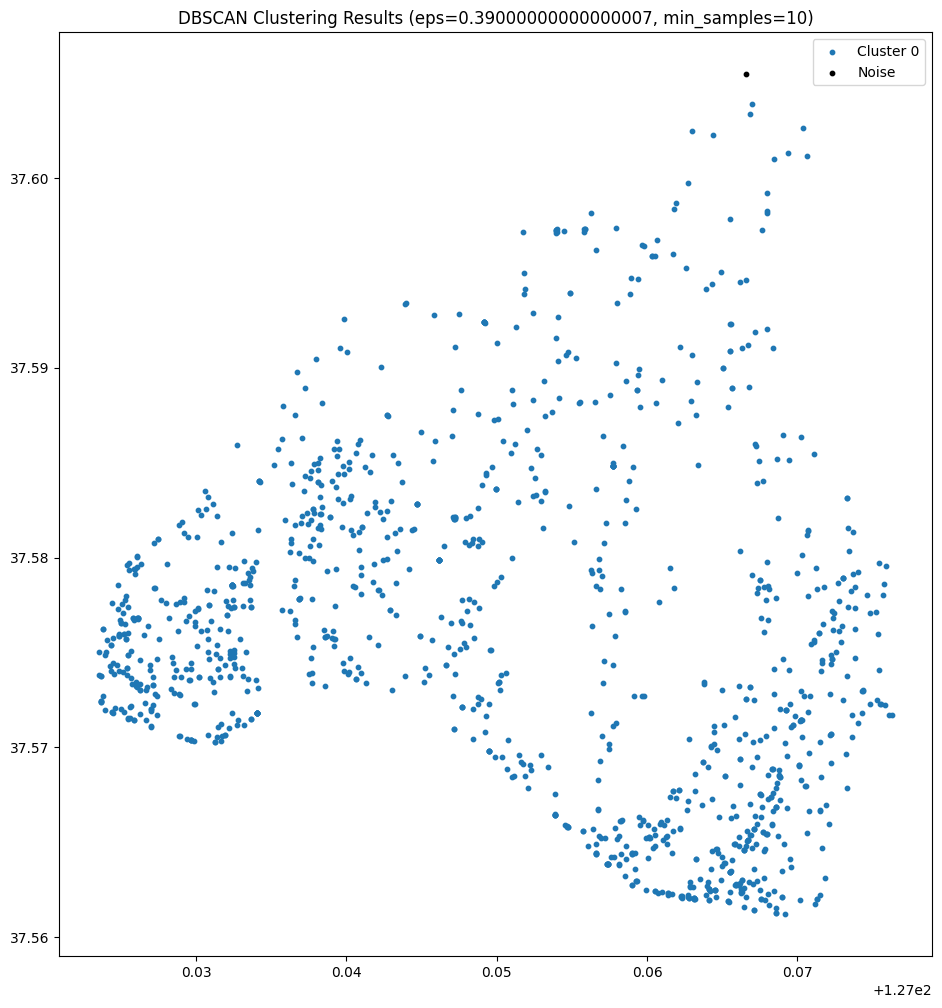

In [ ]:
# DBSCAN 하이퍼파라미터 튜닝
eps_values = np.arange(0.3, 0.4, 0.01)  # eps 범위
min_samples_values = range(5, 15, 1)    # min_samples 범위

heatmap_scores = np.full((len(eps_values), len(min_samples_values)), -1.0)

best_score = -1
best_params = None

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_scaled)

        # 노이즈만 있는 경우 제외
        if len(set(labels)) > 1:
            score = silhouette_score(coords_scaled, labels)
            heatmap_scores[i, j] = score

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

# 최적 파라미터 출력
print(f"Best eps: {best_params[0]}, Best min_samples: {best_params[1]}, Best silhouette score: {best_score}")

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_scores,
    interpolation='nearest',
    cmap='viridis',
    aspect='auto',
    extent=[
        min(min_samples_values), max(min_samples_values),
        max(eps_values), min(eps_values)
    ]
)
plt.colorbar(label='Silhouette Score')
plt.title('DBSCAN Parameter Tuning (Silhouette Score)', fontsize=16)
plt.xlabel('min_samples', fontsize=12)
plt.ylabel('eps', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = best_params
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
corp_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

# 클러스터링 결과 시각화
fig, ax = plt.subplots(figsize=(12, 12))

unique_clusters = corp_gdf['cluster'].unique()

# 색상 설정 (클러스터별로 색상 + 노이즈는 검정색)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = corp_gdf[corp_gdf['cluster'] == cluster_id]
    if cluster_id == -1:  # 노이즈 처리
        cluster_points.plot(ax=ax, markersize=10, color='black', label='Noise')
    else:
        cluster_points.plot(ax=ax, markersize=10, color=color, label=f'Cluster {cluster_id}')

plt.legend()
plt.title(f"DBSCAN Clustering Results (eps={optimal_eps}, min_samples={optimal_min_samples})")
plt.show()

Best eps: 0.17999999999999997, Best min_samples: 9, Best silhouette score: 0.25448218023616787 일 때가 가장 적절해 보인다.

In [ ]:
# 최적 파라미터로 DBSCAN 실행
optimal_eps, optimal_min_samples = 0.17999999999999997, 9
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
corp_gdf['cluster'] = dbscan.fit_predict(coords_scaled)

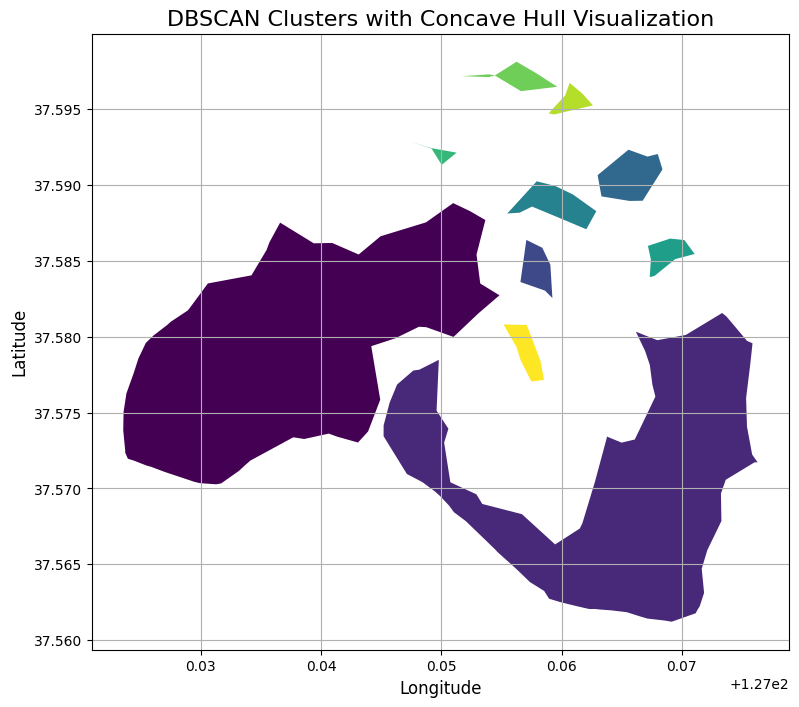

In [ ]:
# Concave Hull 계산
cluster_rows = []

for cluster in corp_gdf['cluster'].unique():
    if cluster == -1:  # Noise는 제외
        continue

    # 특정 클러스터에 속하는 데이터 필터링
    cluster_data = corp_gdf[corp_gdf['cluster'] == cluster]

    # 해당 클러스터의 Concave Hull 계산
    coords = list(zip(cluster_data.geometry.x, cluster_data.geometry.y))

    # Alpha Shape을 사용하여 Concave Hull 생성
    concave_hull = alphashape.alphashape(coords, alpha=500)  # alpha 값 조정 가능

    # Concave Hull 정보 저장
    cluster_rows.append({'cluster': cluster, 'geometry': concave_hull})

# Concave Hull을 포함한 GeoDataFrame 생성
gdf_clusters = gpd.GeoDataFrame(cluster_rows, columns=['cluster', 'geometry'], crs=corp_gdf.crs)

# Concave Hull geometries 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_clusters.plot(ax=ax, cmap='viridis', legend=True)
plt.title('DBSCAN Clusters with Concave Hull Visualization', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
print(gdf_clusters)

output_path = "/content/drive/MyDrive/2024-02-machine-learning/data/dbscaned_corps_clusters.geojson"
gdf_clusters.to_file(output_path, driver="GeoJSON")
print(f"Convex Hull GeoDataFrame saved to {output_path}")

   cluster                                           geometry
0        0  POLYGON ((127.02607 37.58008, 127.02722 37.580...
1        1  POLYGON ((127.05736 37.56383, 127.05662 37.564...
2        2  POLYGON ((127.0584 37.58586, 127.05907 37.5847...
3        3  POLYGON ((127.06332 37.58925, 127.063 37.59065...
4        8  POLYGON ((127.06096 37.58937, 127.06289 37.588...
5        4  POLYGON ((127.06773 37.58401, 127.06734 37.583...
6        5  POLYGON ((127.05127 37.59213, 127.05003 37.591...
7        6  MULTIPOLYGON (((127.05964 37.59647, 127.05663 ...
8        9  POLYGON ((127.05937 37.59465, 127.05892 37.594...
9        7  POLYGON ((127.05853 37.57719, 127.05852 37.577...
Convex Hull GeoDataFrame saved to /content/drive/MyDrive/2024-02-machine-learning/data/dbscaned_corps_clusters.geojson


In [ ]:
# Folium을 사용한 시각화
folium_map = folium.Map(location=[37.5744, 127.0396], tiles="OpenStreetMap", zoom_start=14)

for _, row in gdf_clusters.iterrows():
    cluster_label = row['cluster']
    polygon = row['geometry']

    # Convex Hull을 GeoJSON으로 변환
    geo_json = mapping(polygon)

    folium.GeoJson(
        geo_json,
        name=f"Cluster {cluster_label}",
        style_function=lambda x: {
            "fillColor": "#3186cc",  # 채우기 색상
            "color": "blue",         # 외곽선 색상
            "weight": 2,             # 외곽선 두께
            "fillOpacity": 0.4,      # 채우기 투명도
        },
        tooltip=f"Cluster {cluster_label}"  # 클러스터 ID 표시
    ).add_to(folium_map)

# Folium 지도 저장 및 표시
folium_map